<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Yevin/TabTransformer_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ==============================================================================
# 1. SETUP AND LOAD DATA
# ==============================================================================

# Mount Google Drive to access your pre-processed files
from google.colab import drive
drive.mount('/content/drive')

# Define the directory where your files are saved
DRIVE_OUT = '/content/drive/MyDrive/DiabetesPrediction/TabTrans/outputs'

# Load the training and testing data
try:
    train_df = pd.read_csv(os.path.join(DRIVE_OUT, 'clean_data_train.csv'))
    test_df = pd.read_csv(os.path.join(DRIVE_OUT, 'clean_data_test.csv'))
    meta = joblib.load(os.path.join(DRIVE_OUT, 'meta_info.pkl'))
    print("Files loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please make sure you have run the pre-requirements notebook and the files are in the correct Drive directory.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files loaded successfully!


In [3]:
train_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,1.693635,3.447677,4.848534,3,0.761924,2.496579,0.054263,1
1,1,0.308435,-0.290050,-0.206248,0,0.055526,1.373995,0.047584,1
2,0,-1.014757,-0.290050,-0.206248,0,0.006561,-0.684077,0.518038,0
3,0,0.945914,-0.290050,-0.206248,4,0.094711,3.057872,3.514083,1
4,0,0.358859,-0.290050,-0.206248,4,2.832448,0.438507,-0.129164,1
...,...,...,...,...,...,...,...,...,...
140257,0,0.502746,-0.290050,-0.206248,4,1.537403,3.057872,0.527013,1
140258,1,0.854589,-0.290050,-0.206248,3,0.838827,2.916260,3.514083,1
140259,1,-0.881204,3.447677,-0.206248,0,0.006561,0.438507,0.542798,0
140260,1,0.592462,-0.290050,4.848534,4,0.038968,3.057872,-0.200023,1


In [4]:
# Extract metadata
CAT_COLS = meta['cat_cols']
CONT_COLS = meta['cont_cols']
TARGET_COL = meta['target_col']

In [5]:
# Prepare data for TensorFlow
# The data is already scaled and encoded from your previous notebook
X_train = train_df.drop(TARGET_COL, axis=1)
y_train = train_df[TARGET_COL]

X_test = test_df.drop(TARGET_COL, axis=1)
y_test = test_df[TARGET_COL]

# Separate categorical and continuous features for the model input
X_train_cat = X_train[CAT_COLS].values
X_train_cont = X_train[CONT_COLS].values

X_test_cat = X_test[CAT_COLS].values
X_test_cont = X_test[CONT_COLS].values

In [7]:
# ==============================================================================
# 2. BUILD THE TABTRANSFORMER MODEL
# ==============================================================================
# The model consists of three main parts:
# 1. Categorical Feature Embedder: Converts categorical features into dense vectors.
# 2. Transformer Blocks: A stack of self-attention layers to find relationships.
# 3. Final Classifier: A standard MLP that combines processed categorical features
#    with the original continuous features to make a prediction.

def create_tabtransformer_model(
    cat_dims,
    cont_dim,
    embed_dim=32,
    num_heads=4,
    num_transformer_blocks=4,
    mlp_hidden_units=[64, 32],
    dropout_rate=0.2,
    mlp_dropout=0.3
):
    """Creates a TabTransformer model."""

    # --- Input Layers ---
    # Categorical inputs are integer indices
    cat_inputs = [layers.Input(shape=(1,), name=f'input_cat_{i}') for i in range(len(cat_dims))]
    # Continuous inputs are numerical values
    cont_inputs = layers.Input(shape=(cont_dim,), name='input_cont')

    # --- Categorical Feature Embedding ---
    # Each categorical feature gets its own embedding layer
    embedded_cats = []
    for i, dim in enumerate(cat_dims):
        embedding = layers.Embedding(input_dim=dim, output_dim=embed_dim)(cat_inputs[i])
        embedded_cats.append(embedding)

    # Concatenate embedded features to form a sequence for the Transformer
    categorical_features = layers.Concatenate(axis=1)(embedded_cats) # Shape: (batch, num_cat_features, embed_dim)

    # --- Transformer Blocks ---
    # This is the core of the model where self-attention is applied
    x = categorical_features
    for _ in range(num_transformer_blocks):
        # Multi-Head Attention Layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate
        )(x, x)
        # Skip Connection and Layer Normalization
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-Forward Network
        ffn = keras.Sequential(
            [layers.Dense(embed_dim * 2, activation="relu"), layers.Dense(embed_dim)]
        )
        ffn_output = ffn(x)
        # Skip Connection and Layer Normalization
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Flatten the output of the transformer blocks
    x = layers.Flatten()(x)

    # --- Final Classifier ---
    # Concatenate the processed categorical features with the continuous features
    all_features = layers.Concatenate()([x, cont_inputs])

    # Pass through a final MLP for classification
    for units in mlp_hidden_units:
        all_features = layers.Dense(units, activation="relu")(all_features)
        all_features = layers.Dropout(mlp_dropout)(all_features)

    # Output layer for binary classification
    output = layers.Dense(1, activation="sigmoid")(all_features)

    # Create the Keras model
    model = keras.Model(inputs=[cat_inputs, cont_inputs], outputs=output)
    return model

In [8]:
# Get the number of unique categories for each categorical feature
# This is needed to define the input_dim for the Embedding layers
cat_cardinalities = [len(train_df[col].unique()) for col in CAT_COLS]

In [9]:
# Create the model instance
model = create_tabtransformer_model(
    cat_dims=cat_cardinalities,
    cont_dim=len(CONT_COLS)
)

In [10]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
)

In [11]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_cat_0         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_cat_1         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │         96 │ input_cat_0[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │        192 │ input_cat_1[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 32)     │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 32)     │     16,800 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2, 32)     │          0 │ concatenate[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2, 32)     │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 2, 32)     │      4,192 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 32)     │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 2, 32)     │      4,192 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 2, 32)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ add_3[0][0]     

 Total params: 91,425 (357.13 KB)

 Trainable params: 91,425 (357.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# ==============================================================================
# 3. TRAIN THE MODEL
# ==============================================================================

# The model expects a list of inputs, so we split the categorical features
# into a list of arrays, one for each feature.
X_train_cat_list = [X_train_cat[:, i] for i in range(X_train_cat.shape[1])]
X_test_cat_list = [X_test_cat[:, i] for i in range(X_test_cat.shape[1])]

# Define callbacks for training
# EarlyStopping prevents overfitting by stopping when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

print("\nStarting model training...")

history = model.fit(
    [X_train_cat_list, X_train_cont],
    y_train,
    epochs=100,
    batch_size=256,
    validation_data=([X_test_cat_list, X_test_cont], y_test),
    callbacks=[early_stopping],
    verbose=1
)

print("\nModel training finished.")


Starting model training...
Epoch 1/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.7277 - auc: 0.8004 - loss: 0.5355 - val_accuracy: 0.8816 - val_auc: 0.9578 - val_loss: 0.2775
Epoch 2/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accuracy: 0.8692 - auc: 0.9426 - loss: 0.3096 - val_accuracy: 0.8864 - val_auc: 0.9606 - val_loss: 0.2590
Epoch 3/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 83s 102ms/step - accuracy: 0.8793 - auc: 0.9517 - loss: 0.2821 - val_accuracy: 0.8858 - val_auc: 0.9620 - val_loss: 0.2519
Epoch 4/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 56s 102ms/step - accuracy: 0.8824 - auc: 0.9554 - loss: 0.2704 - val_accuracy: 0.8870 - val_auc: 0.9625 - val_loss: 0.2482
Epoch 5/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 84s 106ms/step - accuracy: 0.8853 - auc: 0.9584 - loss: 0.2608 - val_accuracy: 0.8884 - val_auc: 0.9632 - val_loss: 0.2444
Epoch 6/100
548/548 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.8837 - auc: 0.9593 - loss: 0.2573 - val_accuracy: 0.8894 - val_auc: 0.9641 - val_l


Evaluating model performance on the test set...
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9163 - auc: 0.9800 - loss: 0.1747
Test Loss: 0.1740
Test Accuracy: 0.9147
Test AUC: 0.9800


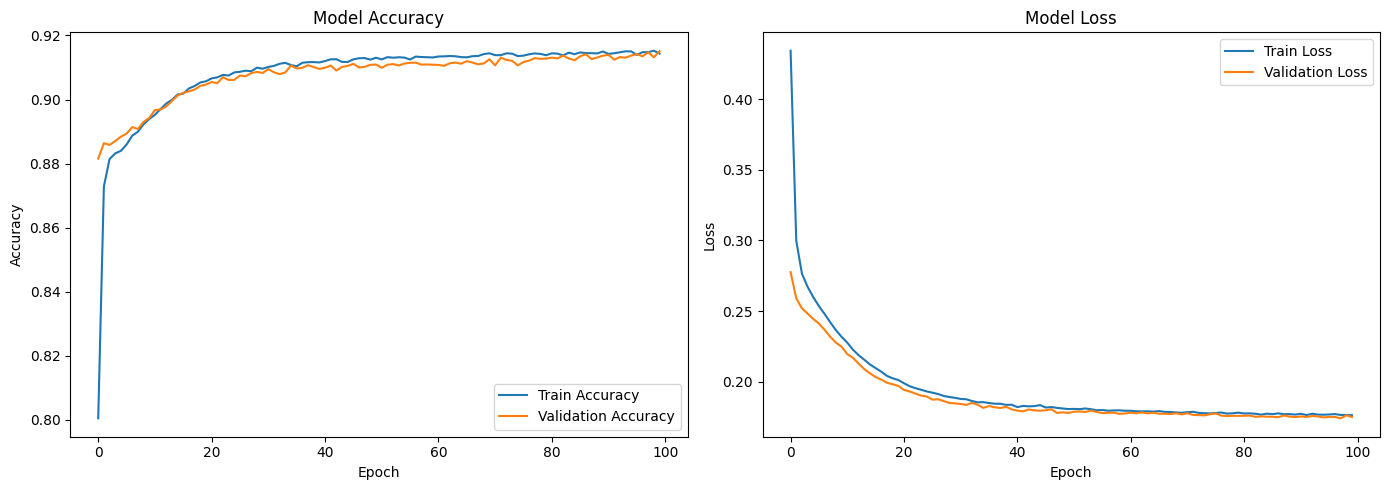

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step

Classification Report:
                 precision    recall  f1-score   support

No Diabetes (0)       0.93      0.90      0.91     17533
   Diabetes (1)       0.90      0.93      0.92     17533

       accuracy                           0.91     35066
      macro avg       0.92      0.91      0.91     35066
   weighted avg       0.92      0.91      0.91     35066

Confusion Matrix:


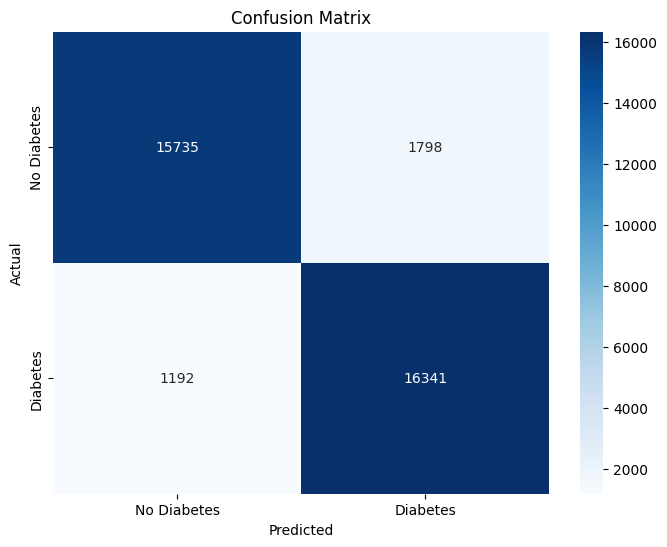

In [13]:
# ==============================================================================
# 4. EVALUATE THE MODEL
# ==============================================================================

print("\nEvaluating model performance on the test set...")
results = model.evaluate([X_test_cat_list, X_test_cont], y_test, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test AUC: {results[2]:.4f}")

# --- Plot Training History ---
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- Classification Report and Confusion Matrix ---
y_pred_proba = model.predict([X_test_cat_list, X_test_cont])
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Diabetes (0)', 'Diabetes (1)']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()